# Sentdex NN with Plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

import pathlib

sns.set_style('darkgrid')


import numpy as np
import argparse
import math
import os
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim

import torch
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from torchmetrics import F1Score

# HBL
from helper import pmath
from helper.helper import get_optimizer, load_dataset 
from helper.hyperbolicLoss import PeBusePenalty

In [3]:
n_c = 10 # Number of classes
dims = 300 # Dimension
samp_size = 1000 # Sample Size
test_prop = 0.2 # Test Proportion
curvature = 1
hpnfile = os.path.join(os.getcwd() + '/prototypes/prototypes-10d-1000c.npy')

path = str(pathlib.Path().resolve())
path_train = path + '/data/syndat/' + str(n_c) + 'c' + str(dims) + 'd' + str(samp_size) + 's' + '_train' + '.csv'
path_test = path + '/data/syndat/' + str(n_c) + 'c' + str(dims) + 'd' + str(samp_size)+ 's' + '_test' + '.csv'
train = pd.read_csv(path_train, index_col=0)
test = pd.read_csv(path_test, index_col=0)

In [4]:
def csv_torch(df):

    # Creating Tuples
    cols = (df.columns)
    rows = np.unique(df.index)

    samps = []

    for i in rows:
        s  = df.loc[int(i),:]
        for j in cols:
            t = torch.Tensor(np.array(s[str(j)]))
            tup = (t, int(i))
            samps.append(tup)
    return samps

In [5]:
dat_train = csv_torch(train)
dat_test = csv_torch(test)

trainset = torch.utils.data.DataLoader(dat_train, batch_size = 10, shuffle = True)
testset = torch.utils.data.DataLoader(dat_test, batch_size = 10, shuffle = True)

# Load the polars and update the trainy labels.
polars = torch.from_numpy(np.load(hpnfile)).float()
# calculate radius of ball
# This part is useful when curvature is not 1.
radius = 1.0 / math.sqrt(curvature)
classpolars = polars * radius

In [6]:
def predict(x):
    x = F.normalize(x, p=2, dim=1)
    x = torch.mm(x, polars.t()) # .cuda())
    return x

In [7]:
hpnfile = 'prototypes/prototypes-10d-1000c.npy'
out_dims = int(hpnfile.split("/")[-1].split("-")[1][:-1]) # if -10d-1-c --> 10 from the d
print(out_dims)
planes = 300

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(dims, planes) # Input Layer
#         self.fc2 = nn.Linear(planes, planes) # Hidden Layer 1
#         self.fc3 = nn.Linear(planes, planes) # Hidden Layer 2
#         self.fc4 = nn.Linear(planes, out_dims) # Output Layer
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x # F.log_softmax(x, dim=1)  We want to sum the classes - across columns


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dims, planes) # Input Layer
        self.fc1_bn = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(planes, planes) # Hidden Layer 1
        self.fc2_bn = nn.BatchNorm1d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(planes, planes) # Hidden Layer 2
        self.fc3_bn = nn.BatchNorm1d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(planes, n_c) # Output Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = (self.fc1_bn(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc3_bn(x)
        x = self.relu2(x)
        x = self.fc4(x)
        return x #  F.log_softmax(x, dim=1) # We want to sum the classes - across columns


net = Net()
print(net)

10
Net(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc1_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc2_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (fc3_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (fc4): Linear(in_features=300, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
hpnfile = 'prototypes/prototypes-1000d-1000c.npy'
out_dims = int(hpnfile.split("/")[-1].split("-")[1][:-1]) # if -10d-1-c --> 10 from the d
print(out_dims)
planes = 300

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dims, planes) # Input Layer
        self.fc1_bn = nn.BatchNorm1d(planes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.fc2 = nn.Linear(planes, planes) # Hidden Layer 1
        self.fc2_bn = nn.BatchNorm1d(planes)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.fc3 = nn.Linear(planes, planes) # Hidden Layer 2
        self.fc3_bn = nn.BatchNorm1d(planes)
        self.relu2 = nn.LeakyReLU(inplace=True)
        self.fc4 = nn.Linear(planes, n_c) # Output Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        x = self.fc1(x)
        x = (self.fc1_bn(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc3_bn(x)
        x = self.relu2(x)
        x = self.fc4(x)
        return x # F.log_softmax(x, dim=1) # We want to sum the classes - across columns


net = Net()
print(net)

1000
Net(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc1_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc2_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (fc3_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (fc4): Linear(in_features=300, out_features=1000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [13]:
x = trainset.dataset[0][0]
x = x.view(-1, dims) # -1 = Any size: Be prepared for any size
max_val = torch.max(x)

In [14]:
x.shape

torch.Size([1, 300])

In [15]:
output = net(x)
output

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 300])

# New Implementation

In [16]:
def fwd_pass(X, y, train = True): # By default, we will not update weights

    avgloss, avglosscount, newloss, acc, newacc = 0., 0., 0., 0., 0.

    target_tmp = y

    y = polars[y]
    X = torch.autograd.Variable(X) # .cuda()
    y = torch.autograd.Variable(y) # .cuda()

    if train:
        net.zero_grad()

    outputs = net(X)
    output_exp_map = pmath.expmap0(outputs, c=1)

    loss = loss_function(output_exp_map, y)

    # Backpropagation.
    if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avgloss += loss.item()
    avglosscount += 1.
    newloss = avgloss / avglosscount

    output = predict(output_exp_map).float()
    pred = output.max(1, keepdim=True)[1]
    acc += pred.eq(target_tmp.view_as(pred)).sum().item()

    trainlen = len(y) # len(trainset.dataset)
    newacc = acc / float(trainlen)

    return newacc, newloss

In [17]:
def test_vals(size = 10):
    counter = 0
    acc_list = []
    loss_list = []

    with torch.no_grad():
        for data in testset:
            counter += 1
            X, y = data
            val_acc, val_loss = fwd_pass(X.view(-1,dims),y, train = False) #.to(device), y.to(device) for cloud computing
            acc_list.append(val_acc)
            loss_list.append(val_loss) # .item()
            if counter == size:
                break

    return float(np.mean(acc_list)), float(np.mean(loss_list))

In [18]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 

net = Net() # .to(device) # <- for cloud GPU
# loss_function = nn.CrossEntropyLoss()

choose_penalty = 'dim'
mult = 0.1
loss_function = PeBusePenalty(out_dims, penalty_option= choose_penalty, mult=mult) # .cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)


def train(net):
    BATCH_SIZE = trainset.batch_size
    EPOCHS = 3

    with open(f"{MODEL_NAME}.log", "a") as f:
        for epoch in range(EPOCHS):
            print(epoch)
            c = 0
            
            for data in trainset:
                c += BATCH_SIZE
                X, y = data
                batch_X = X
                batch_y = y

                batch_X, batch_y = batch_X, batch_y # batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if c % 100 == 0:
                    val_acc, val_loss = test_vals(10)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train(net)

0
1
2


# Visualisation


300


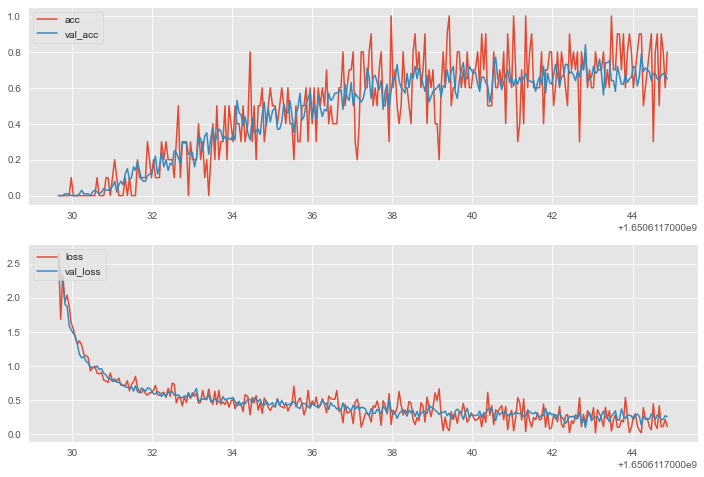

In [19]:
%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib import style

# Multiple lines

style.use('ggplot')
# t = open('model.log', 'r').read().split('\n')
# model_name = t[0][0:16]
# print(model_name)
model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open(f'{MODEL_NAME}.log', 'r').read().split('\n')

    times= []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(',')

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

            
    print(len(accuracies))
    fig = plt.figure(figsize=(12,8))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)

    ax1.plot(times, accuracies, label = 'acc')
    ax1.plot(times, val_accs, label = 'val_acc')
    ax1.legend(loc=2)

    ax2.plot(times, losses, label = 'loss')
    ax2.plot(times, val_losses, label = 'val_loss')
    ax2.legend(loc=2)

    plt.show()

create_acc_loss_graph(model_name)

# HBL First Steps

In [13]:
hpnfile = 'prototypes/prototypes-10d-10c.npy'
int(hpnfile.split("/")[-1].split("-")[1][:-1]) # if -10d-1-c --> 10 from the d

10

In [29]:
path = os.path.join(os.getcwd() + '/prototypes/prototypes-10d-10c.npy')
path

'/Users/dj/Documents/GitHub/Master_Thesis/Code/SynDat_HBL/prototypes/prototypes-10d-10c.npy'

In [33]:
prot = np.load(path)

In [37]:
np.shape(prot)

(10, 10)

In [38]:
prot

array([[-0.25219804,  0.05915433,  0.48179662,  0.11057346, -0.4234488 ,
        -0.05803369, -0.27988303, -0.167969  , -0.2755929 ,  0.56865287],
       [ 0.3219189 ,  0.5471376 , -0.47009853, -0.1778705 , -0.26697284,
         0.09656938, -0.11069116,  0.17349954,  0.35583952,  0.30789837],
       [-0.07103552, -0.06925097, -0.16505356,  0.07408659, -0.46795392,
         0.01751843,  0.7879836 , -0.18669479, -0.17382841, -0.22836283],
       [ 0.22758237, -0.7144217 ,  0.09083306,  0.07330392, -0.19414927,
         0.3286394 , -0.1380258 ,  0.4126377 ,  0.29660642, -0.0344899 ],
       [ 0.28917435,  0.37206653,  0.67150414, -0.25118038,  0.09350803,
        -0.10691381,  0.04996324,  0.20202489,  0.02691147, -0.44690743],
       [-0.45509917, -0.11466437,  0.06544304, -0.34064883,  0.3156396 ,
         0.02156832,  0.09863309, -0.41908994,  0.606029  ,  0.08174947],
       [-0.08859404,  0.08660177, -0.06701314,  0.7534423 ,  0.27503404,
        -0.49810758,  0.06555112,  0.21451604

In [50]:
for data in trainset:
    x , y = data
    print(type(x))
    print(type(y))
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [105]:
for data in trainset:
    avgloss, avglosscount, newloss, acc, newacc = 0., 0., 0., 0., 0.

    X, y = data
    print(len(y))

    target_tmp = y

    y = polars[y]
    X = torch.autograd.Variable(X) # .cuda()
    y = torch.autograd.Variable(y) # .cuda()

    if train:
        net.zero_grad()

    outputs = net(X)
    output_exp_map = pmath.expmap0(outputs, c=1)

    loss = loss_function(output_exp_map, y)

    # Backpropagation.
    if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avgloss += loss.item()
    avglosscount += 1.
    newloss = avgloss / avglosscount

    output = predict(output_exp_map).float()
    pred = output.max(1, keepdim=True)[1]
    print('acc', pred.eq(target_tmp.view_as(pred)))

    acc += pred.eq(target_tmp.view_as(pred)).sum().item()

    trainlen = len(y) # len(trainset.dataset)
    newacc = acc / float(trainlen)
    print(newacc)
    break


10
acc tensor([[False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True]])
0.4


In [100]:
len(trainset.dataset)

10000